# 第十四次课-评分作业

**此次作业<span style="color:red;">成绩计入总评</span>，总分12分，取`min(11, 实际得分)`计入成绩，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW14-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">4月29日23:59前</span>提交**

In [3]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt

## 第一部分、图像处理 (8pt)

In [18]:
# 该函数用于快捷绘图，你可以自由修改使之符合你的需求或绘图习惯
# HW13第二部分开头提供了一个使用这个函数的例子，可供参考
def show_imgs(imgs, titles=None, figsize=(10, 5), arangement=None, cmap=None, **kwargs):
    '''
    Input:
        imgs: 要显示的图像列表，可以含有None表示不绘制相应位置的图像
        titles: 对应每张图像的标题列表
        figsize: 整张图像的尺寸
        arangement: 图像排列方式，是一个整数二元组，如(2, 3)，含义是subplot的前两个参数 
                    如果设为None，则默认为(1, len(imgs))
        cmap: 图像的色彩映射，默认为None，表示RGB；可以设置成'gray'以绘制灰度图
    '''
    assert type(imgs) == list
    n_imgs = len(imgs)
    if arangement is None:
        arangement = (1, n_imgs)
    assert type(arangement) == tuple
    assert n_imgs <= arangement[0] * arangement[1]

    if titles is None or len(titles) != n_imgs:
        titles = [''] * n_imgs
    plt.figure(figsize=figsize)
    for i in range(n_imgs):
        if imgs[i] is None:
            continue
        plt.subplot(arangement[0], arangement[1], i + 1)
        plt.imshow(imgs[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

### 1.1 Hough变换 (2pt)

Hough变换可用于在图像中寻找直线、圆、椭圆等简单几何特征，关于（直线提取）算法的详细介绍可以参考[此链接](https://www.cnblogs.com/php-rearch/p/6760683.html)。通常并不直接在原图上直接进行Hough变换，而是使用边缘检测算子提取灰度图的边缘，再对边缘图进行Hough变换提取相应几何图形。

如果一副图像中含有噪声，边缘检测和Hough变换的效果会受到影响，因此在提取边缘之前应该先对图像平滑去噪

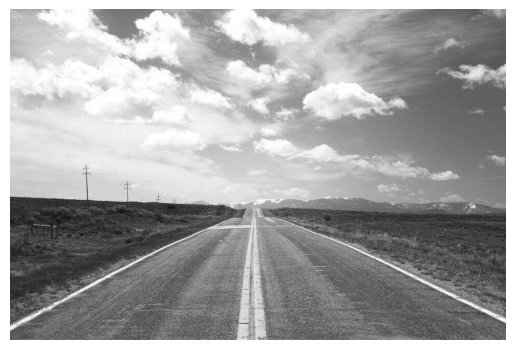

In [3]:
image_path = './HW14-data/imgs/road.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()

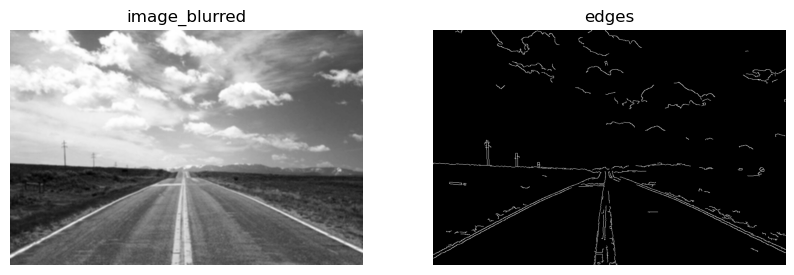

In [15]:
# -------------------------------------------------------------------------
# TODO (1pt): 使用opencv的blur对灰度图进行去噪，并使用Canny边缘检测算法提取灰度图边缘并使用plt展示
# cv2.blur 函数接口参考 https://docs.opencv.org/4.5.5/d4/d86/group__imgproc__filter.html#ga8c45db9afe636703801b0b2e440fce37
# cv2.Canny 函数接口参考 https://docs.opencv.org/4.5.5/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de
# 可能需要调节参数以取得较好的边缘提取效果
# 请将去噪后的图像和边缘提取结果分别命名为 image_blurred 和 edges
# image_blurred = ...
# edges = ...
# -------------------------------------------------------------------------
image_blurred = cv2.blur(image_gray, (5, 5))
edges = cv2.Canny(image_blurred, 64, 128)

show_imgs([image_blurred, edges], ['image_blurred', 'edges'], cmap='gray')

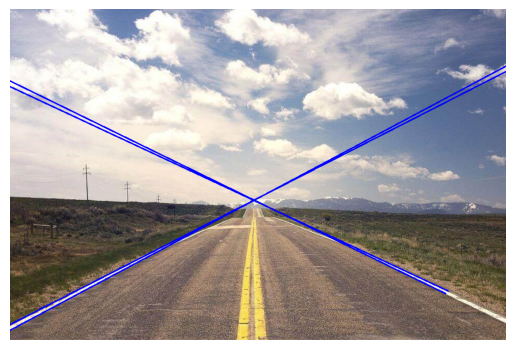

In [19]:
# -------------------------------------------------------------------------
# TODO: (1pt) 使用cv2.HoughLines进行直线检测
# cv2.HoughLines 函数接口参考：https://docs.opencv.org/4.5.5/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a
# 可能需要调节参数以取得较好的边缘提取效果
# 请将HoughLines的返回结果命名为lines
# lines = ...
# -------------------------------------------------------------------------

lines = cv2.HoughLines(edges, 1, np.pi/180, 180)
new_img = image.copy()
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = rho * a
        y0 = rho * b
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)
        cv2.line(new_img, (x1,y1), (x2,y2), (0,0,255), 2)
plt.imshow(new_img)
plt.axis('off')
plt.show()

### 1.2 离散傅里叶变换与离散余弦变换（2pt）

#### 1.2.1 离散傅里叶变换与频域滤波（1pt）

以下单元格供大家熟悉numpy中傅里叶变换的函数接口

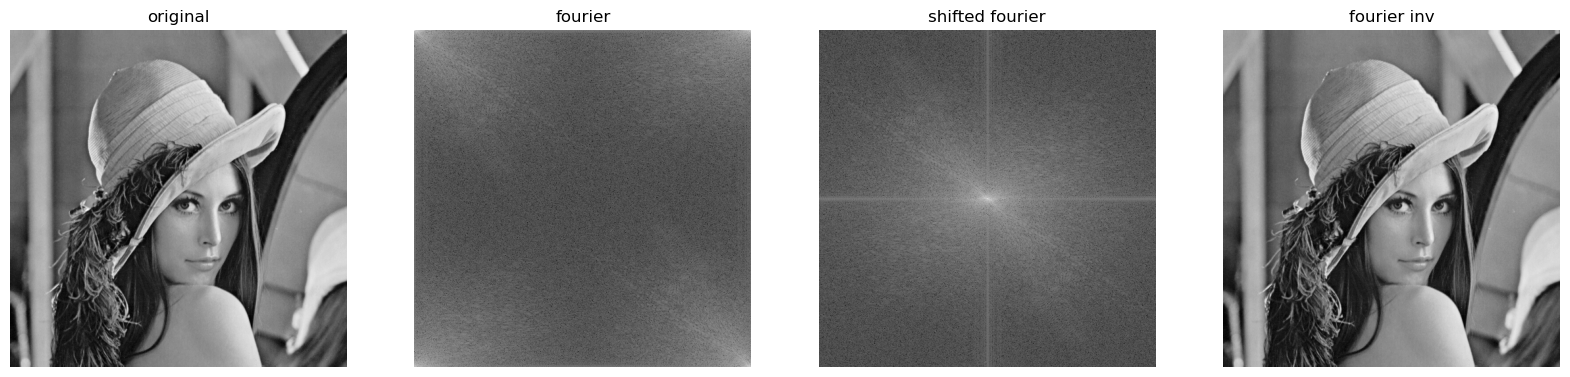

In [20]:
lena_path = './HW14-data/imgs/lena.jpg'
img = cv2.imread(lena_path, 0)

# 使用numpy的快速傅里叶变换函数
fft_img = np.fft.fft2(img)
# 傅里叶变换结果为复数，取模并取对数以更好地显示
fft_img_abs = 20 * np.log(np.abs(fft_img))
# 默认结果中心点位置是在左上角，通过fftshift低频部分移动到图像中心
fft_shift = np.fft.fftshift(fft_img)
fft_shift_abs = 20 * np.log(np.abs(fft_shift))
# 使用numpy的快速傅里叶逆变换函数恢复原图像
img_ifft = np.fft.ifft2(fft_shift) 
# img_ifft = np.fft.ifft2(fft_img) 是等价的
inv_img = np.abs(img_ifft)


show_imgs([img, fft_img_abs, fft_shift_abs, inv_img],
          ['original', 'fourier', 'shifted fourier', 'fourier inv'],
          figsize=(20, 5), cmap='gray')

图像空间（空域）和傅里叶变换得到的频域具有一个特性：其中一个域上的卷积操作$f*g$等价于另一个域上的乘法操作$F\cdot G$，其中$F$和$G$分别是$f$和$g$的傅里叶（逆）变换的结果

我们可以在将图像进行傅里叶变换后，在频域上进行滤波，再逆变换得到处理后的图像，本部分中，我们实现简单的高通滤波和低通滤波，分别去除图像中高频成分和低频成分

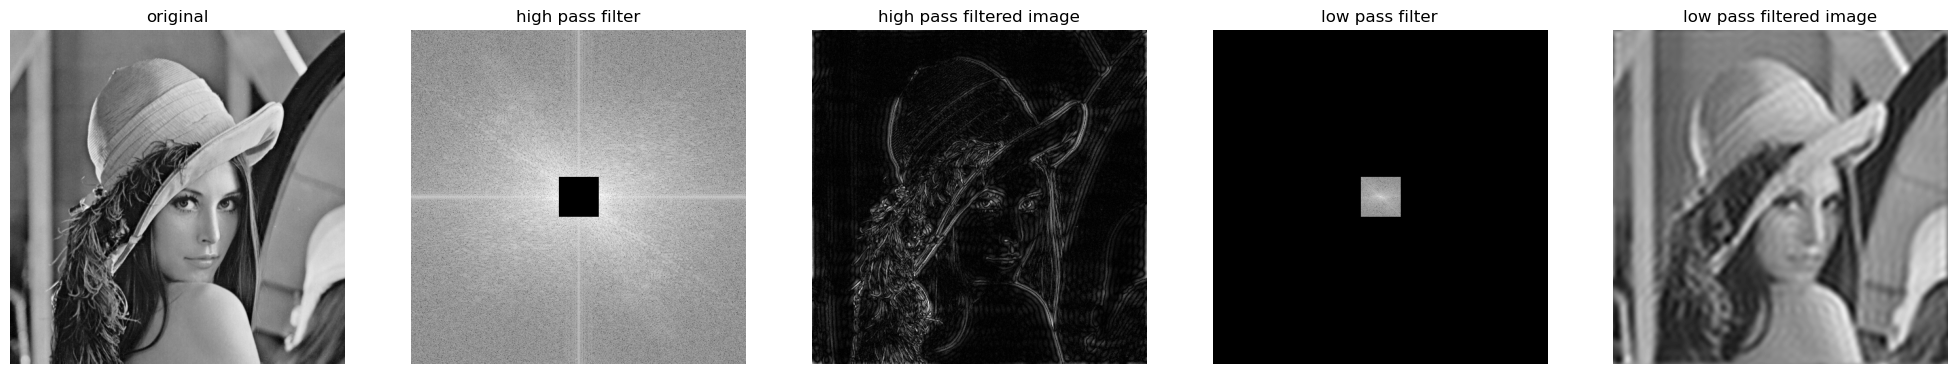

In [23]:
# -------------------------------------------------------------------------
# TODO (1pt) 构造高通滤波矩阵mask_high和低通滤波矩阵mask_low
# 两者的尺寸与灰度图像一致，mask_high中心60*60部分为0，其余部分为1，mask_low中心60*60部分为1，其余部分为0
# mask_high = ...
# mask_low = ...
# -------------------------------------------------------------------------
h, w = img.shape
mask_high = np.ones((h, w))
mask_low = np.zeros((h, w))

mask_high[h//2-30:h//2+31, w//2-30:w//2+31] = 0
mask_low[h//2-30:h//2+31, w//2-30:w//2+31] = 1

fft_shift_high = fft_shift * mask_high
fft_shift_low = fft_shift * mask_low
fft_shift_high_img = np.abs(np.fft.ifft2(fft_shift_high))
fft_shift_low_img = np.abs(np.fft.ifft2(fft_shift_low))

show_imgs(
    [img, np.log(np.abs(fft_shift_high) + 1), fft_shift_high_img, np.log(np.abs(fft_shift_low) + 1), fft_shift_low_img],
    titles=['original', 'high pass filter', 'high pass filtered image', 'low pass filter', 'low pass filtered image'],
    figsize=(25,5), cmap='gray'
)

#### 1.2.2 离散余弦变换与图像加密（1pt）

由于人眼对高频信号较为不敏感，因此对图像中的高频信息进行修改对人的视觉效果影响不大。因此，许多有损图像压缩算法都会忽略或减少高频信息，而隐式数字水印、图像加密等应用场景中也会通过修改高频部分以嵌入肉眼难以察觉的信息。

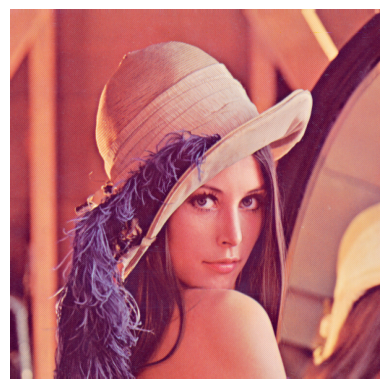

In [24]:
lena_encode_path = './HW14-data/imgs/not_only_lena.bmp'
img = cv2.imread(lena_encode_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


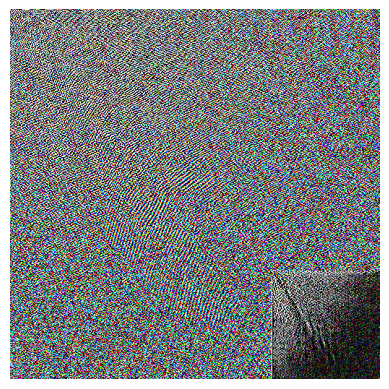

In [25]:
# 输入格式是0~255的浮点数，不需要转换成0~1
img = img.astype(float)

img_dct = np.zeros_like(img) 
img_dct[:, :, 0] = cv2.dct(img[:, :, 0])
img_dct[:, :, 1] = cv2.dct(img[:, :, 1])
img_dct[:, :, 2] = cv2.dct(img[:, :, 2])

plt.imshow(img_dct)
plt.axis('off')
plt.show()

DCT得到的结果中，右下角显然有一块不和谐的小块，已知这个小块的尺寸为150\*150\*三通道，将其提取出来并做逆DCT变换，得到嵌入的加密图像并展示

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


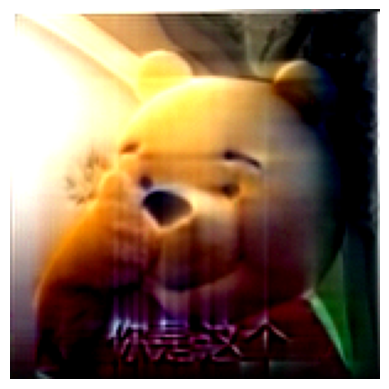

In [48]:
# -------------------------------------------------------------------------
# TODO: (1pt)
# cv2.idct 函数接口参考 https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga77b168d84e564c50228b69730a227ef2
# 与dct一样，idct也需要在三个通道上分别进行
# 你可能需要调整idct所得图像的亮度以获得视觉效果更好的图像

img_patch = img_dct[-150:, -150:, :]
img_idct = np.zeros_like(img_patch) 

img_idct[:, :, 0] = cv2.dct(img_patch[:, :, 0])
img_idct[:, :, 1] = cv2.dct(img_patch[:, :, 1])
img_idct[:, :, 2] = cv2.dct(img_patch[:, :, 2])

plt.imshow(img_idct*0.03)
plt.axis(False)
plt.show()


# -------------------------------------------------------------------------

### 1.3 基于色彩特征的图像聚类（4pt）

图像除了用RGB色彩空间表示外，还可以用HSV色彩空间表示，一般情况下
- H代表色调，用一个0~360中的角度量来表示，按逆时针方向依次有红色为0°，黄色为60°，绿色为120°，青色为180°，蓝色为240°，紫色为300°；
- S代表饱和度，取值范围是0-1，0代表纯黑白灰，1代表纯彩色
- V代表亮度，取值范围是0-1，0代表纯黑，1代表纯白

OpenCV中对HSV的表示进行了重新映射，细节参见[文档](https://docs.opencv.org/4.x/de/d25/imgproc_color_conversions.html#color_convert_rgb_hsv)

此外，还可以定义图像的视彩度（colorfulness），用于衡量图像色彩丰富程度，参见[论文](https://www.researchgate.net/publication/243135534_Measuring_Colourfulness_in_Natural_Images/link/02e7e538488efddec5000000/download?_tp=eyJjb250ZXh0Ijp7ImZpcnN0UGFnZSI6InB1YmxpY2F0aW9uIiwicGFnZSI6InB1YmxpY2F0aW9uIn19)

计算公式总结为
$$
\begin{aligned}
rg &= R-G\\
yb &= \dfrac{1}{2}(R+G)-B\\
\sigma_{rg,yb}&=\sqrt{\sigma_{rg}^2 + \sigma_{yb}^2}\\
\mu_{rg, yb} &= \sqrt{\mu_{rg}^2 + \mu_{yb}^2}\\
\mathrm{colorfulness} &= \sigma_{rg, yb} + 0.3\mu_{rg, yb}
\end{aligned}
$$
其中$R,G,B$表示图像的三通道分量，$\sigma_X$和$\mu_X$表示$X$的标准差和均值

In [14]:
def build_feature(img, method):
    '''
    img: 形如(H, W, 3)的0~255整数类型的RGB图像
    method: 为'h', 's', 'v', 'colorfulness'之一，表示构建特征的方式
    返回一个浮点数，表示构建的特征
    '''
    assert method in ['h', 's', 'v', 'colorfulness']

    # -------------------------------------------------------------------------
    # TODO (1pt): 针对method构建图像特征（一个浮点数）并返回
    # 若method为'h'、's'、'v'中的一个，则返回图像的H/S/V的均值（尽管直接取均值并非一个很好的特征）
    # 若method为'colorfulness'，则依照视彩度公式计算并返回
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H, S, V = cv2.split(hsv)
    if method == 'h':
        return np.mean(H)*2 
    elif method == 's':
        return np.mean(S) / 255
    elif method == 'v':
        return np.mean(V) / 255
    elif method == 'colorfulness':
        R, G, B = cv2.split(img.astype('float'))
        rg = np.abs(R - G)
        yb = np.abs(0.5 * (R + G) - B)

        sigma_rg = np.std(rg)
        sigma_yb = np.std(yb)
        mu_rg = np.mean(rg)
        mu_yb = np.mean(yb)

        sigma = np.sqrt(sigma_rg**2 + sigma_yb**2)
        mu = np.sqrt(mu_rg**2 + mu_yb**2)
        feature = sigma + 0.3 * mu
    
        return feature

    # -------------------------------------------------------------------------

In [1]:
def build_feature(img, method):
    '''
    img: 形如(H, W, 3)的0~255整数类型的RGB图像
    method: 为'h', 's', 'v', 'colorfulness'之一，表示构建特征的方式
    返回一个浮点数，表示构建的特征
    '''
    assert method in ['h', 's', 'v', 'colorfulness']

    # -------------------------------------------------------------------------
    # TODO (1pt): 针对method构建图像特征（一个浮点数）并返回
    # 若method为'h'、's'、'v'中的一个，则返回图像的H/S/V的均值（尽管直接取均值并非一个很好的特征）
    # 若method为'colorfulness'，则依照视彩度公式计算并返回
    img = img.astype('float') / 255
    R, G, B = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    V = max(R, G, B)
    M = min(R, G, B)
    if method == 'h':
        if R == G == B:
            H = 0
        elif V == R:
            H = 60*(G - B)/(V - M)
        elif V == G:
            H = 120 + 60*(B - R)/(V - M)
        elif V == B:
            H = 240 + 60*(R - G)/(V - M)
        feature = H.mean()
    elif method == 's':
        if V != 0:
            S = (V - M) / V
        else:
            S = 0
        feature = S.mean()
    elif method == 'v':
        feature = V.mean()
    elif method == 'colorfulness':
        rg = np.absolute(R - G)
        yb = np.absolute(0.5*(R + G) - B)
        sigma = np.sqrt(np.std(rg)**2 + np.std(yb)**2)
        mu = np.sqrt(np.mean(rg)**2 + np.mean(yb)**2)
        feature = sigma + 0.3*mu
    
    return feature

    # -------------------------------------------------------------------------

In [15]:
posters = []
data_root = './HW14-data/posters'
for file in os.listdir(data_root):
    poster_i = cv2.imread(os.path.join(data_root, file))
    poster_i = cv2.cvtColor(poster_i, cv2.COLOR_BGR2RGB)
    posters.append(poster_i)
random.shuffle(posters)

In [16]:
from sklearn.cluster import KMeans

def run_kmeans_and_plot(n_clusters, method):
    features = np.array([build_feature(poster_i, method) for poster_i in posters]).reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(features)

    labels = kmeans.labels_
    cluster_center = kmeans.cluster_centers_

    for i in range(n_clusters):
        print(f'Cluster {i}, Method {method}, Cluster center: {cluster_center[i]}')

        idx_to_show = np.where(labels == i)[0][:10]
        posters_to_show = [posters[j] for j in idx_to_show]

        show_imgs(posters_to_show)

对HSV和colorfulness提取的特征进行聚类并观察输出结果是否符合预期，你需要自行调节n_clusters以取得相对较好的聚类效果

Cluster 0, Method h, Cluster center: [273.58658358]


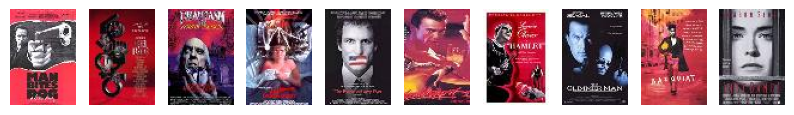

Cluster 1, Method h, Cluster center: [106.69550478]


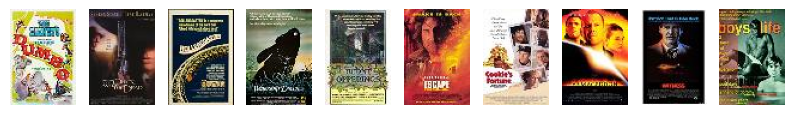

Cluster 2, Method h, Cluster center: [184.2249791]


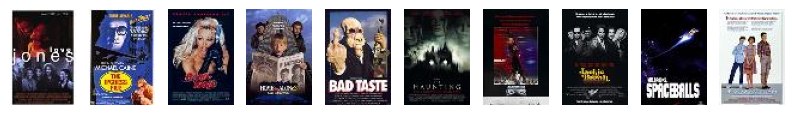

Cluster 3, Method h, Cluster center: [58.76458618]


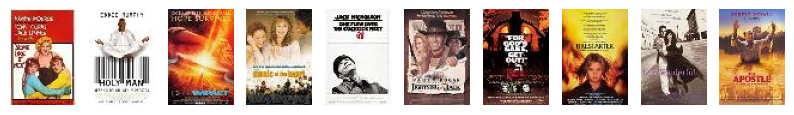

Cluster 4, Method h, Cluster center: [159.37845081]


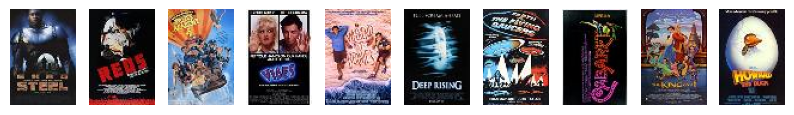

Cluster 5, Method h, Cluster center: [236.95076848]


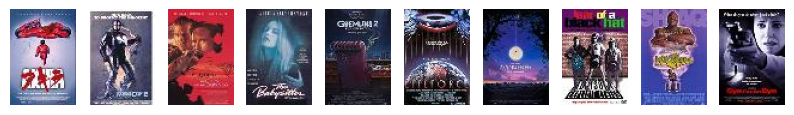

Cluster 6, Method h, Cluster center: [82.70365882]


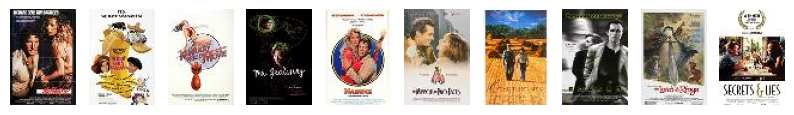

Cluster 7, Method h, Cluster center: [131.76444278]


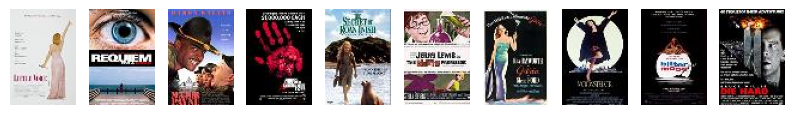

Cluster 8, Method h, Cluster center: [35.95883786]


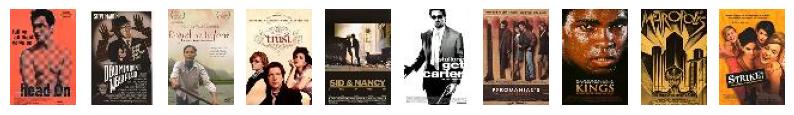

Cluster 9, Method h, Cluster center: [208.93751049]


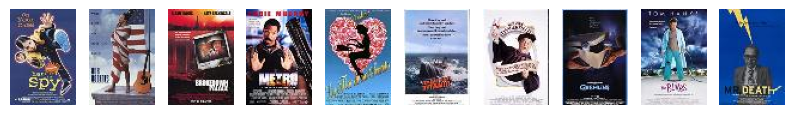

In [19]:
n_cluster_h = 10
run_kmeans_and_plot(n_cluster_h, 'h')
n_cluster_s = 10
run_kmeans_and_plot(n_cluster_s, 's')
n_cluster_v = 10
run_kmeans_and_plot(n_cluster_v, 'v')
n_cluster_colorfulness = 10
run_kmeans_and_plot(n_cluster_colorfulness, 'colorfulness')

# -------------------------------------------------------------------------
# TODO: (1pt) 根据所得结果分析直接取H/S/V均值作为聚类特征的缺陷
# 并针对你发现的缺点提出一种在**其中一种**空间上的特征提取的改进方案（无需实现）
# 注1：并不是把三个空间的均值合并起来聚类就一定能实现优化，如果只希望利用色调H进行聚类，
#      如将深蓝、浅蓝为主的图像归到同一类中，那么加入S和V空间的信息可能会是零优化甚至负优化
# 注2：如果你的改进方式是诸如"使用神经网络""预训练大模型"，你需要进一步分析指出
#      使用什么神经网络/哪种大模型、如何训练、为什么使用这样的模型能改进相应的缺陷等
# 如果想不出改进方式，回顾之前学过的一系列图像特征提取算法可能会有所启发
# 并不需要对三者都进行分析，可以只分析并改进在H/S/V其中一个空间中的特征提取方式
# 
# 
# 
# H均值缺陷：色调是周期性，其中红色可以表示为0和360，意味着非常接近的色调值（1和359）在数值上表现出巨大的差异
# 改进：色调直方图，色调直方图能够更全面地表达一幅图像中所有可能色调的分布情况，从而克服色调平均值可能带来的信息丢失和周期性问题。
# 
# 
# -------------------------------------------------------------------------

In [64]:
# -------------------------------------------------------------------------
# TODO: (2pt) 实现（如果比较复杂，可部分实现）你的改进方案
# 本题评分并无聚类指标上的硬性标准，只要改进方式合理均可
# -------------------------------------------------------------------------
def build_feature_improved(img):
    
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # 计算色调通道的直方图
    feature = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])

    return feature

feature.shape

(180, 1)

## 第二部分、时间序列分析基础（4pt）

本部分中我们使用平安银行的股票数据进行时间序列基础操作与分析

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [43]:
stock_path = './HW14-data/000001.XSHE.csv' # 平安银行，PA
# 由于在plt绘图中显示中文需要做其他设置
# 为简单起见，我们用股票名的前两个字首字母代称，不一定符合业内规范叫法

stock_ = pd.read_csv(stock_path)
display(stock_.head(5))

# 数据说明
# 【date】 交易日期
# 【open】 开盘价
# 【high】 最高价
# 【low】 最低价
# 【close】 收盘价
# 【volume】 成交量
# 【amount】 成交金额

date    open    high     low   close    volume       money
0  2005-01-04  179.52  179.52  175.98  177.62   64637.0  11465603.0
1  2005-01-05  177.62  178.44  172.99  175.98  118279.0  20718559.0
2  2005-01-06  177.07  179.52  175.71  177.62   97879.0  17333840.0
3  2005-01-07  179.25  179.80  175.98  177.35   69237.0  12302853.0
4  2005-01-10  177.35  179.52  173.53  179.52   96618.0  17111498.0

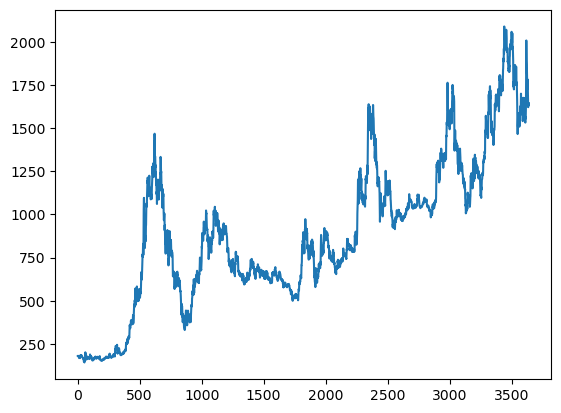

In [44]:
# 本次作业中只使用最高价数据
stock = stock_['high']
plt.plot(stock)
plt.show()

### 2.1 成分分解 (1pt)

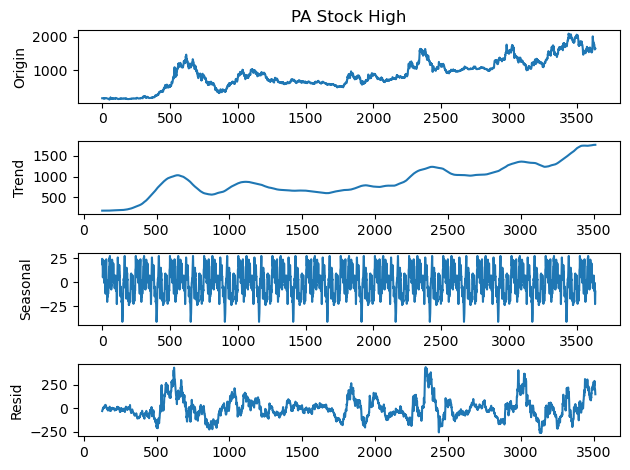

In [48]:
# -------------------------------------------------------------------------
# TODO: (1pt) 使用**加法**分解作用于PA数据并绘制分解后的图像
# 使用statsmodels中的seasonal_decompose，接口参考如下
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html


# -------------------------------------------------------------------------


ss_decomposition = seasonal_decompose(x=stock, model='additive', period=252)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

plt.figure()

plt.subplot(411)
plt.plot(stock)
plt.title("PA Stock High")
plt.ylabel("Origin")

plt.subplot(412)
plt.plot(estimated_trend)
plt.ylabel("Trend")

plt.subplot(413)
plt.plot(estimated_seasonal)
plt.ylabel("Seasonal")

plt.subplot(414)
plt.plot(estimated_residual)
plt.ylabel("Resid")

plt.tight_layout()
plt.show()

### 2.2 平稳序列（1pt）

对数据迭代地进行差分，直到得到一个平稳序列(p_value<0.05)，绘制原始序列和最终得到的序列

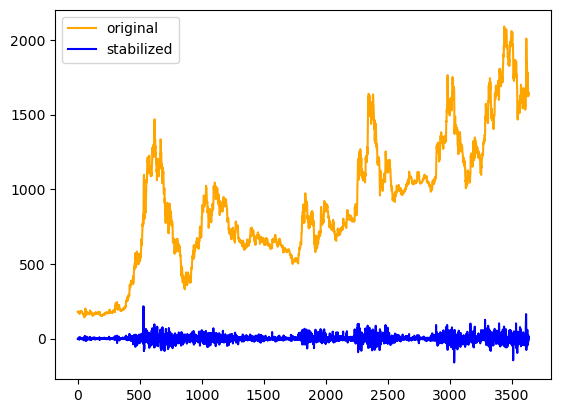

In [49]:
# -------------------------------------------------------------------------
# TODO (1pt)
# 可以使用adfuller检验平稳性获取p_value，函数接口参考如下
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html#statsmodels.tsa.stattools.adfuller

# -------------------------------------------------------------------------
def toStationary(data, alpha):
    while True:
        data = np.diff(data)
        result = adfuller(data)
        if result[1] < alpha:
            break
    return data

stationary = toStationary(stock, 0.05)
plt.figure()
plt.plot(stock, label='original', c='orange')
plt.plot(stationary, label="stabilized", c='b')
plt.legend()
plt.show()

### 2.3 滑动窗口与平滑（2pt）

#### 2.3.1 均值与标准差（1pt）

对于大小为30的滑动窗口，在滑动窗口内计算均值与标准差并绘制图像

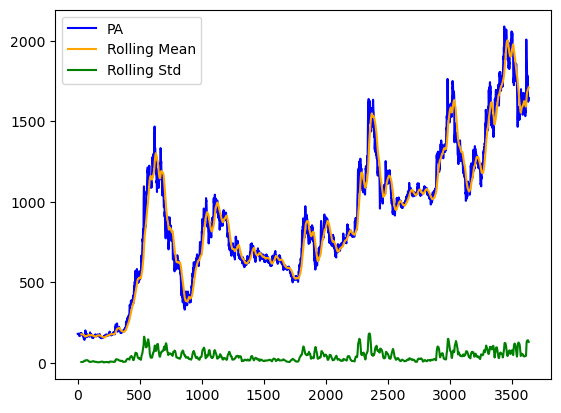

In [51]:
# -------------------------------------------------------------------------
# TODO (1pt)
pa_mean = stock.rolling(window=30).mean()
pa_std = stock.rolling(window=30).std()

plt.figure()
plt.plot(stock, label='PA', c='b')
plt.plot(pa_mean, label='Rolling Mean', c='orange')
plt.plot(pa_std, label='Rolling Std', c='g')
plt.legend()
plt.show()


# -------------------------------------------------------------------------

#### 2.3.2 二次指数平滑（1pt）

均值滑动平均的窗口内各个点的权重相同，而指数平滑对过去的数据赋予不同权重，距离现在时刻更近的观测值被赋予更大的权重。二次指数平滑引入两个平滑参数$\alpha$和$\beta$，分别用于平滑水平(level)和趋势(trend)

二次指数平滑的公式如下
$$l_{t} = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})$$
$$b_{t} = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}$$

其中$y_t$为原始数据，$l_t$为平滑后的水平，$b_t$为平滑后的趋势，认为$l_{-1}=b_{-1}=0$

平滑后的数据$\hat{y}$的计算公式为
$$
\hat{y}_{t+h} = l_t + hb_t
$$
其中$h$为窗口大小，$0\leq t\leq t_{\max}-h$

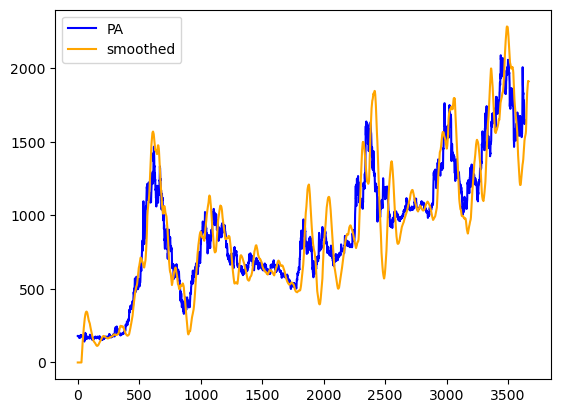

In [59]:
# -------------------------------------------------------------------------
# TODO: (1pt) 对数据进行二次指数平滑，绘制平滑结果和原图像
# 参数取alpha=0.03, beta=0.06, h=30
alpha = 0.03
beta = 0.06
h = 30

l = [0]*(len(stock))
b = [0]*(len(stock))
stock_hat = [0]*(len(stock) + h)

for i in range(1, len(stock)):
    l[i] = alpha * stock[i] + (1 - alpha) * (l[i-1] + b[i-1])
    b[i] = beta * (l[i] - l[i-1]) + (1 - beta) * b[i-1]
    stock_hat[i+h] = l[i] + h*b[i]

plt.figure()
plt.plot(stock, label='PA', c='b')
plt.plot(stock_hat, label='smoothed', c='orange')
plt.legend()
plt.show()


# -------------------------------------------------------------------------